In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from io import StringIO
import requests
import seaborn as sns
from datetime import timedelta  
import matplotlib.ticker as ticker

from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_forecast_component, plot_components_plotly

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
good_ids = ['u00', 'u01', 'u02', 'u03', 'u04', 'u05', 'u07', 'u09', 'u10',
             'u14', 'u15', 'u16', 'u17', 'u18', 'u19', 'u20', 'u23', 'u24',
             'u27', 'u30', 'u31', 'u32', 'u33', 'u34', 'u35', 'u36', 'u42',
             'u43', 'u44', 'u45', 'u47', 'u49', 'u51', 'u52', 'u53', 'u54',
             'u56', 'u58', 'u59', 'u46']

len(good_ids)  

40

# Utilities

In [ ]:
%load_ext google.colab.data_table

In [ ]:
project_id = 'ipads-8-300914'

In [ ]:
%env GCLOUD_PROJECT=ipads-8-300914

env: GCLOUD_PROJECT=ipads-8-300914


In [ ]:
# Source: https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py

import time

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.
    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1
        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.
        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query, legacy = False):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """        
        my_job = self.client.query(query, job_config=bigquery.job.QueryJobConfig(use_legacy_sql=legacy, dry_run = True))
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query, legacy = False):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query, job_config=bigquery.job.QueryJobConfig(use_legacy_sql=legacy))
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(data=[list(x.values()) for x in results], columns=list(results[0].keys()))

In [ ]:
bq_assistant = BigQueryHelper('ipads-8-300914', 'studentlife')

# Requests for summary statistics

In [ ]:
#individual summary statistics of activity data
QUERY_activity_ind = '''
SELECT
  id AS id,
  COUNT(_activity_inference) AS number_of_measurements, 
  AVG(_activity_inference) AS mean_activtiy_level,
  MIN(_activity_inference) AS min_activity_level,
  MAX(_activity_inference) AS max_activity_level,
FROM
  `ipads-8-300914.studentlife.activity`
GROUP BY id
'''

In [ ]:
#combined summary statistics of activity data
QUERY_activity_comb = '''
SELECT
  COUNT(_activity_inference) AS number_of_measurements, 
  AVG(_activity_inference) AS mean_activtiy_level,
  MIN(_activity_inference) AS min_activity_level,
  MAX(_activity_inference) AS max_activity_level,
FROM
  `ipads-8-300914.studentlife.activity`
'''


In [ ]:
#individual summary statistics of stress data
QUERY_stress_ind = '''
SELECT
  id AS id,
  COUNT(level) AS number_of_measurements, 
  AVG(level) AS mean_stress_level,
  MIN(level) AS min_stress_level,
  MAX(level) AS max_stress_level,
FROM
  `ipads-8-300914.studentlife.stress`
GROUP BY id
'''

In [ ]:
#combined summary statistics of stress data
QUERY_stress_comb = '''
SELECT
  COUNT(level) AS number_of_measurements, 
  AVG(level) AS mean_stress_level,
  MIN(level) AS min_stress_level,
  MAX(level) AS max_stress_level,
FROM
  `ipads-8-300914.studentlife.stress`
'''

In [ ]:
#count on how many days the inidviduals have been responding
QUERY_responding_days = '''
SELECT 
  id,
  COUNT(DISTINCT(EXTRACT(DATE FROM TIMESTAMP_SECONDS(resp_time)))) AS Days_with_response,
  79-COUNT(DISTINCT(EXTRACT(DATE FROM TIMESTAMP_SECONDS(resp_time)))) AS missing_days,
FROM   ipads-8-300914.studentlife.stress
GROUP BY id
ORDER BY id
'''


In [ ]:
print(bq_assistant.estimate_query_size(QUERY_activity_ind))
print(bq_assistant.estimate_query_size(QUERY_activity_comb))
print(bq_assistant.estimate_query_size(QUERY_stress_ind))
print(bq_assistant.estimate_query_size(QUERY_stress_comb))
print(bq_assistant.estimate_query_size(QUERY_responding_days))

0.2346659218892455
0.14440979808568954
2.2761523723602295e-05
1.4007091522216797e-05
2.2761523723602295e-05


In [ ]:
individual_activity_summary = bq_assistant.query_to_pandas(QUERY_activity_ind)
individual_activity_summary

id  number_of_measurements  ...  min_activity_level  max_activity_level
0   u00                  461991  ...                   0                   3
1   u01                  474862  ...                   0                   3
2   u02                  527518  ...                   0                   3
3   u03                  411402  ...                   0                   3
4   u04                  462516  ...                   0                   3
5   u05                  471647  ...                   0                   3
6   u07                  388016  ...                   0                   3
7   u09                  489438  ...                   0                   3
8   u10                  531159  ...                   0                   3
9   u14                  451115  ...                   0                   3
10  u15                  245896  ...                   0                   3
11  u16                  490749  ...                   0                   3
12  u17                  526248  ...                   0                   3
13  u18                  443776  ...                   0                   3
14  u19                  525619  ...                   0                   3
15  u20                  354198  ...                   0                   3
16  u23                  468330  ...                   0                   3
17  u24                  249841  ...                   0                   3
18  u27                  509670  ...                   0                   3
19  u30                  494845  ...                   0                   3
20  u31                  496697  ...                   0                   3
21  u32                  472947  ...                   0                   3
22  u33                  423140  ...                   0                   3
23  u34                  362581  ...                   0                   3
24  u35                  536077  ...                   0                   3
25  u36                  521156  ...                   0                   3
26  u42                  361829  ...                   0                   3
27  u43                  400298  ...                   0                   3
28  u44                  471864  ...                   0                   3
29  u45                  406876  ...                   0                   3
30  u46                  430927  ...                   0                   3
31  u47                  397781  ...                   0                   3
32  u49                  612741  ...                   0                   3
33  u51                  537914  ...                   0                   3
34  u52                  241461  ...                   0                   3
35  u53                  477052  ...                   0                   3
36  u54                  331358  ...                   0                   3
37  u56                  469698  ...                   0                   3
38  u58                  505755  ...                   0                   3
39  u59                 1945367  ...                   0                   3

[40 rows x 5 columns]

In [ ]:
print(np.min(individual_activity_summary.mean_activtiy_level))
print(np.max(individual_activity_summary.mean_activtiy_level))

0.024253649714877416
0.42138481990880455


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



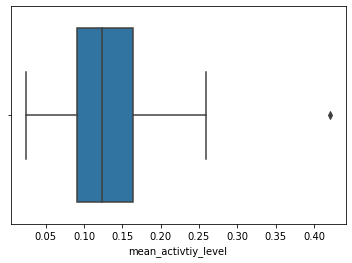

In [ ]:
sns.boxplot(individual_activity_summary.mean_activtiy_level)

In [ ]:
combined_activity_summary = bq_assistant.query_to_pandas(QUERY_activity_comb)
combined_activity_summary

number_of_measurements  ...  max_activity_level
0                19382355  ...                   3

[1 rows x 4 columns]

In [ ]:
individual_stress_summary =  bq_assistant.query_to_pandas(QUERY_stress_ind)
individual_stress_summary

id  number_of_measurements  ...  min_stress_level  max_stress_level
0   u44                      87  ...                 1                 5
1   u05                       8  ...                 1                 5
2   u52                      41  ...                 1                 5
3   u09                       3  ...                 1                 4
4   u33                      58  ...                 1                 5
5   u32                      66  ...                 1                 5
6   u24                      39  ...                 1                 5
7   u49                      61  ...                 1                 5
8   u53                      38  ...                 1                 4
9   u04                      43  ...                 1                 4
10  u45                      28  ...                 1                 5
11  u19                      91  ...                 1                 5
12  u58                      55  ...                 1                 5
13  u23                      44  ...                 1                 4
14  u35                      39  ...                 1                 5
15  u42                      29  ...                 1                 5
16  u15                      10  ...                 1                 4
17  u03                      29  ...                 1                 5
18  u54                      20  ...                 1                 4
19  u02                      30  ...                 1                 5
20  u14                      37  ...                 1                 4
21  u43                      77  ...                 1                 5
22  u34                       6  ...                 1                 4
23  u59                     269  ...                 1                 5
24  u18                      16  ...                 1                 4
25  u56                      19  ...                 1                 5
26  u01                      32  ...                 1                 5
27  u17                      42  ...                 1                 3
28  u16                     107  ...                 1                 4
29  u00                      74  ...                 1                 5
30  u20                      10  ...                 1                 4
31  u36                      56  ...                 1                 4
32  u07                      53  ...                 1                 5
33  u46                      33  ...                 1                 5
34  u31                      12  ...                 1                 5
35  u27                      25  ...                 1                 4
36  u30                      30  ...                 1                 5
37  u47                      13  ...                 1                 4
38  u10                     106  ...                 1                 5
39  u51                      44  ...                 1                 4

[40 rows x 5 columns]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



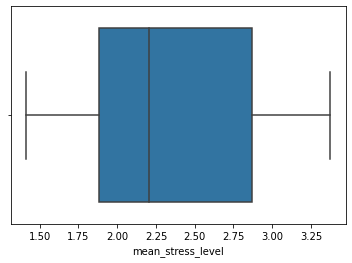

In [ ]:
sns.boxplot(individual_stress_summary.mean_stress_level)

In [ ]:
combined_stress_summary =  bq_assistant.query_to_pandas(QUERY_stress_comb)
combined_stress_summary

number_of_measurements  ...  max_stress_level
0                    1880  ...                 5

[1 rows x 4 columns]

In [ ]:
responding_days =  bq_assistant.query_to_pandas(QUERY_responding_days)
responding_days

id  Days_with_response  missing_days
0   u00                  46            33
1   u01                  26            53
2   u02                  27            52
3   u03                  19            60
4   u04                  27            52
5   u05                   4            75
6   u07                  19            60
7   u09                   3            76
8   u10                  40            39
9   u14                  27            52
10  u15                   7            72
11  u16                  54            25
12  u17                  35            44
13  u18                  13            66
14  u19                  55            24
15  u20                   8            71
16  u23                  24            55
17  u24                  23            56
18  u27                  17            62
19  u30                  19            60
20  u31                  12            67
21  u32                  36            43
22  u33                  35            44
23  u34                   5            74
24  u35                  29            50
25  u36                  36            43
26  u42                  19            60
27  u43                  34            45
28  u44                  47            32
29  u45                  20            59
30  u46                  21            58
31  u47                  11            68
32  u49                  44            35
33  u51                  32            47
34  u52                  30            49
35  u53                  28            51
36  u54                  16            63
37  u56                  16            63
38  u58                  40            39
39  u59                  70             9

# Requests for Imputing and summarizing data

In total the study ran for 79 days (unique days in the stress dataset)

25.03.2013-16.08.2013 (does that make sense? Longer than 10 weeks, 79 days. 

Official dartmouth calender: https://www.dartmouth.edu/reg/calendar/term/2013-03.html

Start of lectures: 25.03.2013
Final examination period ends: 31.05.2013


In [ ]:
#Get daily summary of stress levels for each individual and imputing missing data
QUERY_daydata_stress = '''
 SELECT id, date, 
         COALESCE(daily_stress_avg, last_value(daily_stress_avg ignore nulls) over (order by id, date)) as daily_stress_avg
         
 FROM
  (
    (SELECT id , date
    FROM `ipads-8-300914.studentlife.id_dates`) AS dt
   LEFT JOIN 
    (SELECT id AS id1,
        EXTRACT(DATE FROM TIMESTAMP_SECONDS(resp_time)) AS date1,
        AVG(level) AS daily_stress_avg
     FROM   ipads-8-300914.studentlife.stress
     GROUP BY id1, date1
     ORDER BY id1, date1) AS sd
   ON dt.id = sd.id1
   AND dt.date = sd.date1)
 '''
 #results are saved in gitlab

In [ ]:
#Get daily summary of activity levels for each individual and imputing missing data
QUERY_daydata_activity = '''
 SELECT id, date, 
         COALESCE(daily_act_avg, last_value(daily_act_avg ignore nulls) over (order by id, date)) as daily_act_avg
         
 FROM
  (
    (SELECT id , date
    FROM `ipads-8-300914.studentlife.id_dates`) AS dt
   LEFT JOIN 
    (SELECT id AS id1,
        EXTRACT(DATE FROM TIMESTAMP_SECONDS(timestamp)) AS date1,
        AVG(_activity_inference) AS daily_act_avg
     FROM   ipads-8-300914.studentlife.activity
     GROUP BY id1, date1
     ORDER BY id1, date1) AS sd
   ON dt.id = sd.id1
   AND dt.date = sd.date1)
 '''
 #results are saved in gitlab

In [ ]:
print(bq_assistant.estimate_query_size(QUERY_daydata_stress))
print(bq_assistant.estimate_query_size(QUERY_daydata_activity))


In [ ]:
daily_stress_avg = bq_assistant.query_to_pandas(QUERY_daydata_stress)

In [ ]:
daily_act_avg = bq_assistant.query_to_pandas(QUERY_daydata_activity)

# Time Series analysis

In [ ]:
# load csv results from BigQuery requests saved as csv files in gitlab (saves GBQ space)
# adding csv files from GitLab to Google Colab is required

daily_stress_avg = pd.read_csv('ind_daily_stress_avg.csv') 
# from GBQ: 
# daily_stress_avg = bq_assistant.query_to_pandas(QUERY_daydata_stress)
daily_stress_avg['date'] = pd.to_datetime(daily_stress_avg['date'])
daily_stress_avg.fillna(daily_stress_avg.mean(), inplace=True)

daily_act_avg = pd.read_csv('ind_daily_activity_avg.csv') 
# from GBQ:
# daily_act_avg = bq_assistant.query_to_pandas(QUERY_daydata_activity)
daily_act_avg['date'] = pd.to_datetime(daily_act_avg['date'])
daily_act_avg.fillna(daily_act_avg.mean(), inplace=True)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [ ]:
# split 4 timeseries into usual components:
stress_u10 = daily_stress_avg[daily_stress_avg['id'] == 'u10'][{"date", "daily_stress_avg"}].rename(columns = {"date":"ds", 'daily_stress_avg': 'y'})
stress_u16 = daily_stress_avg[daily_stress_avg['id'] == 'u16'][{"date", "daily_stress_avg"}].rename(columns = {"date":"ds", 'daily_stress_avg': 'y'})

activity_u10 = daily_act_avg[daily_act_avg['id'] == 'u10'][{"date", "activity_level"}].rename(columns = {"date":"ds", 'activity_level': 'y'})
activity_u16 = daily_act_avg[daily_act_avg['id'] == 'u16'][{"date", "activity_level"}].rename(columns = {"date":"ds", 'activity_level': 'y'})

stress = pd.DataFrame(index = list(stress_u10.ds), data = np.array([ list(stress_u10.y), list(stress_u16.y)]).T, columns = [ 'u10', 'u16'])
activity = pd.DataFrame(index = list(activity_u10.ds), data = np.array([ list(activity_u10.y), list(activity_u16.y)]).T, columns = [ 'u10', 'u16'])

Text(0, 0.5, 'stress level')

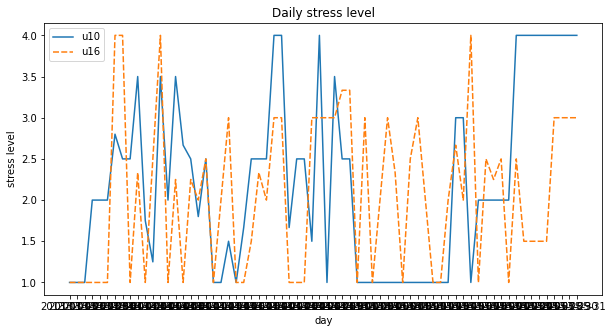

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = sns.lineplot(data = stress)
plt.title('Daily stress level')
plt.xlabel('day')
plt.ylabel('stress level')

Text(0, 0.5, 'stress level')

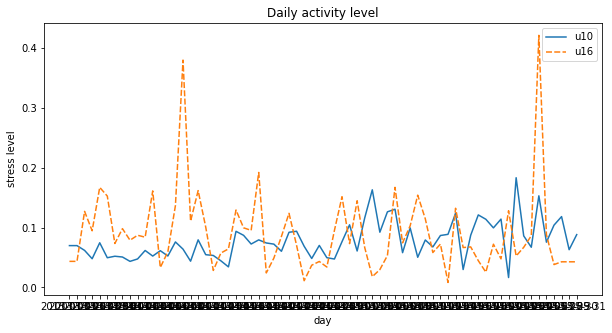

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = sns.lineplot(data = activity)
plt.title('Daily activity level')
plt.xlabel('day')
plt.ylabel('stress level')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


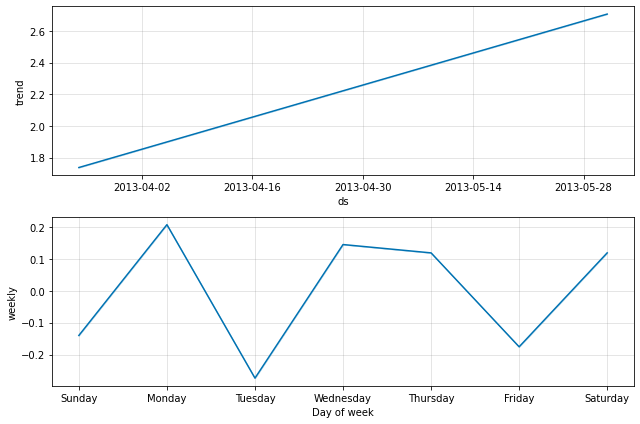

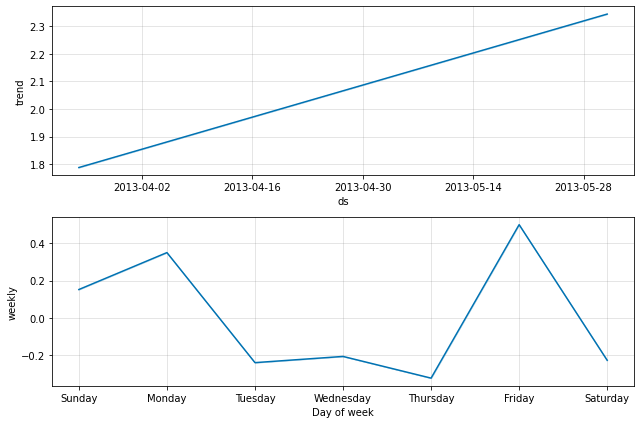

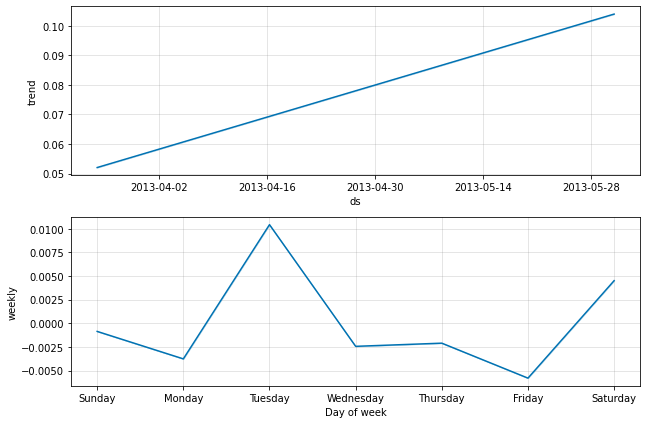

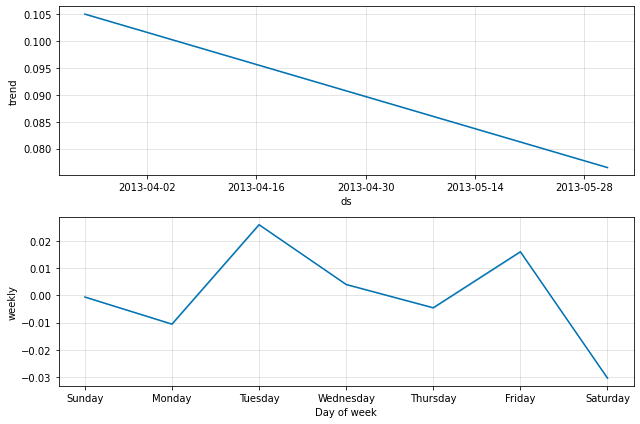

In [ ]:
m = Prophet()
m.fit(stress_u10)
forecast = m.predict(stress_u10)
p1 = plot_components(m, forecast)
p1.savefig("stress_u10.png")

m = Prophet()
m.fit(stress_u16)
forecast = m.predict(stress_u16)
p2 = plot_components(m, forecast)
p2.savefig("stress_u16.png")



m = Prophet()
m.fit(activity_u10)
forecast = m.predict(activity_u10)
p3 = plot_components(m, forecast)
p3.savefig("activity_u10.png")


m = Prophet()
m.fit(activity_u16)
forecast = m.predict(activity_u16)
p4 = plot_components(m, forecast)
p4.savefig("activity_u16.png")




# Correlation analysis

In [ ]:
# correlation analysis

from scipy.stats import pearsonr 

c10,p10 = pearsonr(stress["u10"], activity['u10'])
c16,p16 = pearsonr(stress["u16"], activity['u16'])
print("Correlation of u10: {}, p Value: {}".format(c10,p10))
print("Correlation of u16: {}, p Value: {}".format(c16,p16))

Correlation of u10: 0.06554216060126901, p Value: 0.5954009454705459
Correlation of u16: -0.17489519880215854, p Value: 0.15372256511298224


In [ ]:
#individual correlations for each user
corr_rs = []
p_vals = []
for user in good_ids:
  r,p = pearsonr(daily_stress_avg[daily_stress_avg['id'] == user]['daily_stress_avg'], daily_act_avg[daily_act_avg['id'] == user]['activity_level'])
  corr_rs.append(r)
  p_vals.append(p)
corr_rs = np.array(corr_rs)
p_vals = np.array(p_vals)
print("Mean correlations of all users: {}, mean p-value: {}".format(np.mean(corr_rs), np.mean(p_vals)))

Mean correlations of all users: -0.01597519611212621, mean p-value: 0.45488412442666365


In [ ]:
#correlation for all users
corr, p = pearsonr(daily_stress_avg['daily_stress_avg'], daily_act_avg['activity_level'])
print("Overall correlation: {}, p-value: {}".format(corr, p))

#Positive correlation between stress and activity would be unlikely, bad p-value

Overall correlation: 0.022272680806490766, p-value: 0.24555609683612103


In [ ]:
stress_array = np.array(daily_stress_avg.pivot(index = "date", columns = "id", values = "daily_stress_avg"))
activity_array = np.array(daily_act_avg.pivot(index = "date", columns = "id", values = "activity_level"))

In [ ]:
#Correlation for overall average

daily_activity = (np.mean(activity_array, axis = 1))
daily_stress = (np.mean(stress_array, axis = 1))

corr, p = pearsonr(daily_stress, daily_activity)

print("Correlation on daily average data across all participants: {}, p-value: {}".format(corr, p))


Correlation on daily average data across all participants: 0.3709628969232397, p-value: 0.0018441028594030455


In [ ]:
#Correlation for overall average


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



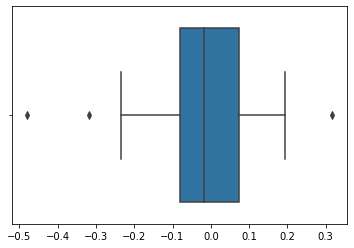

In [ ]:
sns.boxplot(corr_rs)

In [ ]:
# finding significant correlations after bonferroni correcture
sig_p_vals = p_vals[p_vals<=0.05/40]
sig_corr_coeff = corr_rs[p_vals<=0.05/40]
user = np.array(good_ids)[p_vals<=0.05/40]
print("Significant p-Values: {}, corresponding significant correlation coefficients: {}, users: {}".format(sig_p_vals, sig_corr_coeff, user))

Significant p-Values: [3.55208385e-05], corresponding significant correlation coefficients: [-0.47926607], users: ['u14']


Correlations between components from Prophet

In [ ]:
corr_rs_trend = []
p_vals_trend = []
corr_rs_weekly = []
p_vals_weekly = []



for user in good_ids:
  print(user)
  stress_user = daily_stress_avg[daily_stress_avg['id'] == user][{"date", "daily_stress_avg"}].rename(columns = {"date":"ds", 'daily_stress_avg': 'y'})
  activity_user = daily_act_avg[daily_act_avg['id'] == user][{"date", "activity_level"}].rename(columns = {"date":"ds", 'activity_level': 'y'})

  m_act = Prophet()
  m_act.fit(activity_user)
  act_forecast = m_act.predict(activity_user)
  activity_weekly = act_forecast["weekly"]
  activity_trend = act_forecast["trend"]

  m_stress = Prophet()
  m_stress.fit(stress_user)
  stress_forecast = m_stress.predict(stress_user)
  stress_weekly = stress_forecast["weekly"]
  stress_trend = stress_forecast["trend"]


  r_weekly,p_weekly = pearsonr(stress_weekly, activity_weekly)

  r_trend,p_trend = pearsonr(stress_trend, activity_trend)

  corr_rs_trend.append(r_trend)
  corr_rs_weekly.append(r_weekly)
  p_vals_trend.append(p_trend)
  p_vals_weekly.append(p_weekly)

corr_rs_trend = np.array(corr_rs_trend)
corr_rs_weekly = np.array(corr_rs_weekly)
p_vals_trend = np.array(p_vals_trend)
p_vals_weekly = np.array(p_vals_weekly)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u00


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u01


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u02


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u03


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u04


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u05


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u07


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u09


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u10


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u14


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u15


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u16


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u17


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u18


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u19


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u20


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u23


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u24


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u27


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u30


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u31


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u32


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u33


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u34


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u35


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u36


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u42


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u43


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u44


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u45


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u47


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u49


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u51


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u52


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u53


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u54


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u56


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u58


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u59


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


u46


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
print("Mean correlation of all users for trend component: {}, mean p-value: {}".format(np.mean(corr_rs_trend), np.mean(p_vals_trend)))
print("Mean correlation of all users for weekly component: {}, mean p-value: {}".format(np.mean(corr_rs_weekly), np.mean(p_vals_weekly)))

Mean correlation of all users for trend component: 0.0999907539388483, mean p-value: 1.9381039021668648e-107
Mean correlation of all users for weekly component: 0.0420881258143558, mean p-value: 0.09520591602656307


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



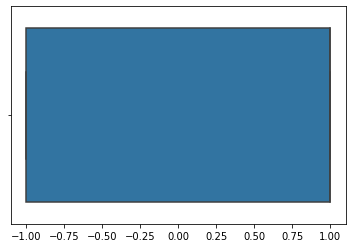

In [ ]:
sns.boxplot(corr_rs_trend)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



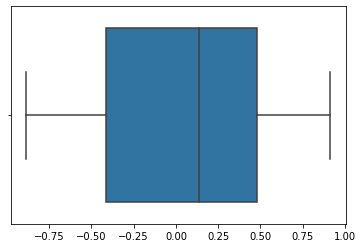

In [ ]:
sns.boxplot(corr_rs_weekly)

In [ ]:
sig_p_vals_trend = p_vals_trend[p_vals_trend<=0.05/40]
sig_corr_coeff_trend = corr_rs_trend[p_vals_trend<=0.05/40]
user_trend = np.array(good_ids)[p_vals_trend<=0.05/40]

sig_p_vals_weekly = p_vals_weekly[p_vals_weekly<=0.05/40]
sig_corr_coeff_weekly = corr_rs_weekly[p_vals_weekly<=0.05/40]
user_weekly = np.array(good_ids)[p_vals_weekly<=0.05/40]

print("Significant p-Values for trend analysis: {}, corresponding significant correlation coefficients: {}, users: {}".format(sig_p_vals_trend, sig_corr_coeff_trend, user_trend))
print("Significant p-Values for weekly analysis: {}, corresponding significant correlation coefficients: {}, users: {}".format(sig_p_vals_weekly, sig_corr_coeff_weekly, user_weekly))

Significant p-Values for trend analysis: [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.95566887e-292 7.75241561e-106 0.00000000e+000 1.01645737e-255
 0.00000000e+000 3.86255079e-185 5.45253154e-164 0.00000000e+000
 1.75490703e-198 8.60318278e-296 1.46904327e-260 1.02233913e-208
 1.29463903e-155 1.26750844e-307 1.02108904e-214 0.00000000e+000
 4.25905204e-184 0.00000000e+000 1.48514562e-187 1.46785988e-184
 0.00000000e+000 6.74848642e-178 0.00000000e+000 0.00000000e+000
 1.89429170e-220 1.34299704e-314 0.00000000e+000 0.00000000e+000
 0.00000000e+000 3.26280953e-320 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 9.74795319e-233], corresponding significant correlation coefficients: [-1.          1.         -1.          1.         -1.          0.99964968
 -1.          0.99999999  1.         -0.99999862  0.99999394 -1.
  0.99999945 -1.         -0.99999999  0.99999973  0.99998914  1.
 -0.99999982 -1.         -0.99999851  1.          0.

In [ ]:
print("Number of significant trend analysis: {}".format(len(sig_p_vals_trend)))
print("Number of significant weekly analysis: {}".format(len(sig_p_vals_weekly)))

Number of significant trend analysis: 40
Number of significant weekly analysis: 26


# Further Stress correlation requests

In [ ]:
conv_dur = '''
SELECT
  id AS id,
  AVG(_end_timestamp	-start_timestamp) AS mean_conv_dur,
FROM
  `ipads-8-300914.studentlife.conversation`
GROUP BY id
ORDER BY id
'''

In [ ]:
conv_freq = '''
SELECT id as id,
AVG(conv_freq_day) as mean_conv_freq
  FROM (
    SELECT id as id,
    EXTRACT(DATE FROM TIMESTAMP_SECONDS(start_timestamp) AT TIME ZONE "EST")  as date,
    COUNT(1) AS conv_freq_day,
    FROM `ipads-8-300914.studentlife.conversation`
    GROUP BY id, date
  )
GROUP BY id
ORDER BY id
'''

In [ ]:
conv_freq_day_night='''
SELECT   id                   AS id, 
         Sum(conv_freq_day)   AS mean_conv_freq_day, 
         Sum(conv_freq_night) AS mean_conv_freq_night 
FROM    ( 
                  SELECT   id AS id, 
                           CASE 
                                    WHEN( 
                                                      day=1) THEN Avg(conv_freq_day_ev) 
                                    ELSE 0 
                           END AS conv_freq_day, 
                           CASE 
                                    WHEN( 
                                                      day=0) THEN Avg(conv_freq_day_ev) 
                                    ELSE 0 
                           END AS conv_freq_night 
                  FROM     ( 
                                    SELECT   id   AS id, 
                                             date AS date, 
                                             CASE 
                                                      WHEN time > "20:00:00" THEN 0 
                                                      WHEN time < "6:00:00" THEN 0 
                                                      ELSE 1 
                                             END      AS day, 
                                             Count(1) AS conv_freq_day_ev 
                                    FROM     ( 
                                                    SELECT id                                                                       AS id,
                                                           Extract(time FROM Timestamp_seconds(start_timestamp) at time zone "EST") AS time,
                                                           Extract(date FROM Timestamp_seconds(start_timestamp) at time zone "EST") AS date,
                                                    FROM   `ipads-8-300914.studentlife.conversation` ) 
                                    GROUP BY id, 
                                             date, 
                                             day) 
                  GROUP BY id, 
                           day) 
GROUP BY id 
ORDER BY id
'''

In [ ]:
conv_dur_day_night = '''
SELECT   id                  AS id, 
         Sum(conv_dur_day)   AS mean_conv_dur_day, 
         Sum(conv_dur_night) AS mean_conv_dur_night 
FROM    ( 
                  SELECT   id AS id, 
                           CASE 
                                    WHEN( 
                                                      day=1) THEN Avg(conv_dur_day_ev) 
                                    ELSE 0 
                           END AS conv_dur_day, 
                           CASE 
                                    WHEN( 
                                                      day=0) THEN Avg(conv_dur_day_ev) 
                                    ELSE 0 
                           END AS conv_dur_night 
                  FROM     ( 
                                    SELECT   id   AS id, 
                                             date AS date, 
                                             CASE 
                                                      WHEN time > "20:00:00" THEN 0 
                                                      WHEN time < "6:00:00" THEN 0 
                                                      ELSE 1 
                                             END           AS day, 
                                             Sum(conv_dur) AS conv_dur_day_ev, 
                                    FROM     ( 
                                                    SELECT id                                                                       AS id,
                                                           (_end_timestamp - start_timestamp)                                       AS conv_dur,
                                                           Extract(time FROM Timestamp_seconds(start_timestamp) at time zone "EST") AS time,
                                                           Extract(date FROM Timestamp_seconds(start_timestamp) at time zone "EST") AS date,
                                                    FROM   `ipads-8-300914.studentlife.conversation` ) 
                                    GROUP BY id, 
                                             date, 
                                             day) 
                  GROUP BY id, 
                           day) 
GROUP BY id 
ORDER BY id
'''

In [ ]:
print(bq_assistant.estimate_query_size(conv_freq))
print(bq_assistant.estimate_query_size(conv_dur))
print(bq_assistant.estimate_query_size(conv_freq_day_night))
print(bq_assistant.estimate_query_size(conv_dur_day_night))

0.0007954183965921402
0.0012849066406488419
0.0007954183965921402
0.0012849066406488419


In [ ]:
df_conv_freq_day_night = bq_assistant.query_to_pandas(conv_freq_day_night)

In [ ]:
df_conv_dur_day_night = bq_assistant.query_to_pandas(conv_dur_day_night)

In [ ]:
df_conv_dur =  bq_assistant.query_to_pandas(conv_dur)

In [ ]:
df_conv_freq = bq_assistant.query_to_pandas(conv_freq)

In [ ]:
conversation = pd.DataFrame(df_conv_freq_day_night)
conversation = conversation.join(df_conv_dur_day_night.set_index('id'), on='id')
conversation = conversation.join(df_conv_dur.set_index('id'), on='id')
conversation = conversation.join(df_conv_freq.set_index('id'), on='id')

In [ ]:
stress_level_day_night = '''
SELECT id AS id,
       SUM(mean_level_day) AS mean_stress_level_day,
       SUM(mean_level_night) AS mean_stress_level_night
  FROM(SELECT   id                                                     AS id,
           CASE WHEN(day=1) THEN Avg(mean_level_per_day) ELSE 0 END AS mean_level_day,
           CASE WHEN(day=0) THEN Avg(mean_level_per_day) ELSE 0 END AS mean_level_night
  FROM     ( 
                             SELECT 
                             id AS id,
                             date AS date,
                             CASE 
                                      WHEN time > "20:00:00" THEN 0 
                                      WHEN time < "6:00:00" THEN 0 
                                      ELSE 1 
                             END      AS day, 
                             AVG(level) as mean_level_per_day,
                    FROM     ( 
                                    SELECT id                                                                 AS id,
                                           level                                                              AS level,
                                           EXTRACT(time FROM Timestamp_seconds(resp_time) at time zone "EST") AS time,
                                           EXTRACT(date FROM Timestamp_seconds(resp_time) at time zone "EST") AS date,
                                    FROM   `ipads-8-300914.studentlife.stress` ) 
                    GROUP BY id, 
                             date, 
                             day)
  GROUP BY id, day)
GROUP BY id
ORDER BY id
'''

In [ ]:
stress_level = '''
SELECT 
         id AS id,
         AVG(level) as mean_stress_level,
FROM     ( 
                SELECT id                                                                 AS id,
                       level                                                              AS level,
                FROM   `ipads-8-300914.studentlife.stress` ) 
GROUP BY id
'''

In [ ]:
stress_level_pre = '''
SELECT id                              AS id,
       pss                             AS pss_pre,
FROM   `ipads-8-300914.studentlife.pss`
WHERE type = 'pre'
ORDER BY id
'''

In [ ]:
stress_level_post = '''
SELECT id                              AS id,
       pss                             AS pss_post,
FROM   `ipads-8-300914.studentlife.pss`
WHERE type = 'post'
ORDER BY id
'''

In [ ]:
df_stress_level_pre = bq_assistant.query_to_pandas(stress_level_pre)
df_stress_level_post = bq_assistant.query_to_pandas(stress_level_post)

In [ ]:
df_stress = pd.DataFrame(df_stress_level_pre)
df_stress = df_stress.join(df_stress_level_post.set_index('id'), on='id')

In [ ]:
df_correlation = pd.DataFrame(df_stress)
df_correlation = df_correlation.join(conversation.set_index('id'), on='id')

In [ ]:
def plotCorrelation(df):
    #f = plt.figure(figsize=(10, 10))
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,10))
    #fig(figsize=(10,10))
    corr = df.corr(method="pearson")
    ax.matshow(corr)
    for (i, j), z in np.ndenumerate(corr):
      ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
    ax.set_title("Correlation Matrix")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(range(df.shape[1]))
    ax.set_xticklabels(df.columns, fontsize=10, rotation=90)
    ax.set_yticks(range(df.shape[1]))
    ax.set_yticklabels(df.columns, fontsize=8)
    #pcm = ax.pcolormesh()
    cb = fig.colorbar(ax.imshow(corr),ax=ax)
    #cb.ax.tick_params(labelsize=10)
    plt.show()

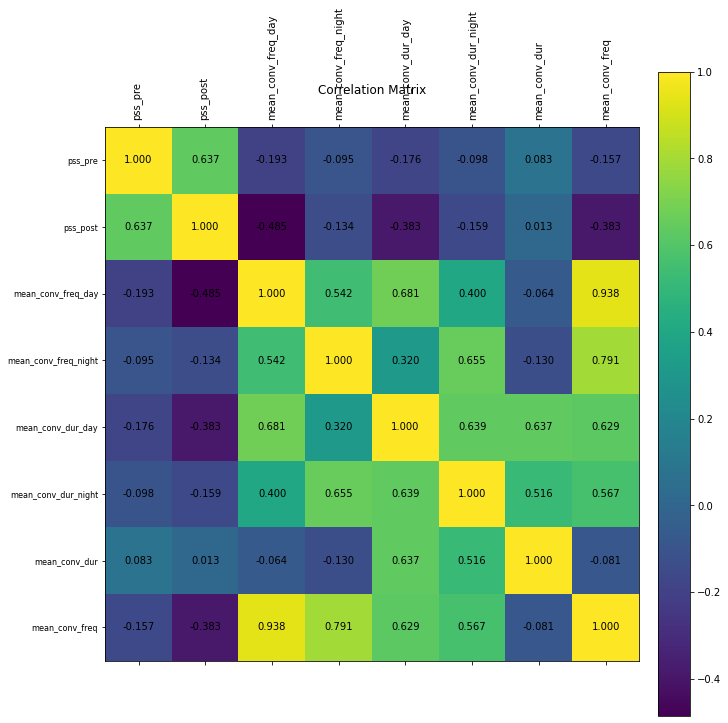

In [ ]:
plotCorrelation(df_correlation.loc[:, df_correlation.columns != 'id'])

In [ ]:
df_correlation

id  pss_pre  pss_post  ...  mean_conv_dur_night  mean_conv_dur  mean_conv_freq
0   u00     24.0      15.0  ...          3368.048387     760.111795       32.476923
1   u01     15.0      16.0  ...         10259.872727     764.026159       39.618182
2   u02     21.0      25.0  ...          5906.654545     849.729602       22.815385
3   u03     17.0      24.0  ...          1329.714286     519.866109       11.116279
4   u04     21.0      17.0  ...          5011.122807     550.232371       47.189655
5   u05      7.0       7.0  ...          3420.456140     662.570732       25.625000
6   u07     12.0      28.0  ...          4555.209302     588.976693       30.511111
7   u09     13.0      17.0  ...          7052.796610     755.657118       34.378788
8   u10     20.0      15.0  ...          2382.245283     510.745133       33.731343
9   u14      9.0      14.0  ...          8052.816667     871.337946       29.359375
10  u15     22.0      11.0  ...          5497.424242     734.803232       23.377778
11  u16     24.0      26.0  ...          5508.346154     596.967499       30.767857
12  u17     33.0      34.0  ...          1659.000000     626.042264       21.476923
13  u18     27.0      24.0  ...          4997.025000     739.227402       23.355556
14  u19     20.0      21.0  ...          3703.226415     620.862989       29.578947
15  u20     14.0      18.0  ...          2898.022222     451.978137       21.040000
16  u23     27.0      22.0  ...          2288.137255     472.834981       22.672414
17  u24     18.0      14.0  ...          9945.785714     734.900763       33.806452
18  u27     18.0      23.0  ...          5378.177419     459.150995       35.111111
19  u30      9.0      12.0  ...          7855.301587     917.590888       32.921875
20  u31     22.0      21.0  ...          6230.548387     463.342074       40.555556
21  u32      3.0       8.0  ...          7265.941176     836.494629       34.910714
22  u33     33.0      33.0  ...          4534.280000    1051.056541       17.018868
23  u34     14.0      14.0  ...          5265.781250     612.045654       29.973684
24  u35     14.0      16.0  ...          3264.063830     537.219341       22.650794
25  u36     12.0      18.0  ...          3406.290909     418.650993       33.578947
26  u42     24.0      15.0  ...          4355.382353     601.419355       26.068182
27  u43     21.0      13.0  ...          5038.720000     602.821490       30.910714
28  u44     18.0      20.0  ...          1646.365854     456.995717       24.578947
29  u45     21.0      20.0  ...          5465.775000     632.503574       26.229167
30  u46     31.0      30.0  ...         10248.240741     754.106974       35.314815
31  u47     14.0      28.0  ...          2793.977778     400.430155       18.040000
32  u49     16.0       8.0  ...          4168.739130     525.607100       33.240000
33  u51     14.0      12.0  ...          2804.945455     452.856921       29.784615
34  u52     22.0      29.0  ...          2643.255319     460.849614       11.969231
35  u53     23.0      20.0  ...          5174.387097     563.770822       29.158730
36  u54     19.0      26.0  ...          5968.564103     626.647754       27.000000
37  u56     11.0       9.0  ...          3305.352941     513.384831       24.982456
38  u58     20.0       NaN  ...          6397.448980     846.889203       26.735849
39  u59     18.0      13.0  ...          8210.417910     393.540514       60.970149

[40 rows x 9 columns]

In [ ]:
from scipy.stats import pearsonr 
def pairwise_corr(x,y):
  y = y.dropna()
  x = x.dropna()
  y = x
  corr, p = pearsonr(x, y)
  print("Overall correlation: {}, p-value: {}".format(corr, p))

In [ ]:
pairwise_corr(df_correlation['mean_conv_dur'],df_correlation['pss_post'])

ValueError: ignored

In [ ]:
x = df_correlation['mean_conv_dur'].dropna()
y = df_correlation['pss_post'].dropna()
x

0      760.111795
1      764.026159
2      849.729602
3      519.866109
4      550.232371
5      662.570732
6      588.976693
7      755.657118
8      510.745133
9      871.337946
10     734.803232
11     596.967499
12     626.042264
13     739.227402
14     620.862989
15     451.978137
16     472.834981
17     734.900763
18     459.150995
19     917.590888
20     463.342074
21     836.494629
22    1051.056541
23     612.045654
24     537.219341
25     418.650993
26     601.419355
27     602.821490
28     456.995717
29     632.503574
30     754.106974
31     400.430155
32     525.607100
33     452.856921
34     460.849614
35     563.770822
36     626.647754
37     513.384831
38     846.889203
39     393.540514
Name: mean_conv_dur, dtype: float64

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def norm(y_vec):
  return (y_vec-np.min(y_vec))/(np.max(y_vec)/np.min(y_vec))
  
#Training and testing data as numpy arrays 

#X # np.arrays of all values that should be used for analysis (shape: n_samples, n_features)
#y # np.arrays of the median_stress variable (shape: n_samples)

#normalize y between 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

regr.fit(X_train, y_train)

r = regr.score(X_test, y_test)

print("The r^2 score on the stress predicition was {}".format(r))



The r^2 score on the stress predicition was 0.8848385237121386


In [ ]:
X.shape

(10, 5)

In [ ]:
y.shape


(10,)